In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import numpy as np

In [2]:
class Policy:
    def __init__(self):
        self.alpha = 0.01
        self.policy = keras.models.Sequential([
            keras.layers.Dense(25, activation="relu", input_shape=[25]),
            keras.layers.Dense(10, activation="relu"),
            keras.layers.Dense(5, activation="softmax"),
        ])
        self.policy.compile(optimizer=Adam(learning_rate=self.alpha))
        
    def __call__(self, state):
        pi = self.policy(state)
        return pi
    
def get_obs(array, pos):
    obs = []
    i, j = pos
    for ii in range(-2, 3, 1):
        row = []
        for jj in range(-2, 3, 1):
            row.append(array[(i + ii) % len(array)][(j + jj) % len(array)])
        obs.append(row)     
    return obs

def apply_action(array, pos, action):
    i, j = pos
    if action == 0:
        array[i][j], array[i][(j + 1) % len(array)] = array[i][(j + 1) % len(array)], array[i][j]
    elif action == 1:
        array[i][j], array[i][(j - 1)] = array[i][(j - 1)], array[i][j]
    elif action == 2:
        array[i][j], array[i - 1][j] = array[i - 1][j], array[i][j]
    elif action == 3:
        array[i][j], array[i + 1][j] = array[(i + 1) % len(array)][j], array[i][j]

In [3]:
import gym
import random

In [4]:
types = [0, 1, 2]

In [5]:
obs = [[random.choice(types) for i in range(5)] for j in range(5)]
obs[2][2] = 1

In [6]:
array = np.array([[random.choice(types) for i in range(10)] for j in range(10)])

In [7]:
array

array([[0, 1, 1, 0, 1, 0, 2, 0, 2, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 2, 2, 2, 1, 0, 0, 1, 2, 1],
       [1, 0, 1, 1, 2, 0, 2, 2, 1, 1],
       [1, 2, 2, 1, 0, 2, 1, 2, 0, 0],
       [1, 0, 2, 1, 0, 0, 0, 2, 1, 1],
       [2, 0, 2, 0, 2, 1, 1, 0, 1, 2],
       [2, 2, 1, 1, 2, 0, 1, 0, 2, 2],
       [0, 2, 1, 1, 0, 1, 1, 2, 0, 0],
       [0, 1, 1, 1, 0, 2, 0, 2, 1, 2]])

## Create Environment

In [8]:
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete
import random

In [9]:
'''
Lets create environment that we have just onde predator in initial middle of table
'''
class PPEnv(Env):
    def __init__(self, L=5, time_limit=40, pos=(0, 0)):
        self.L = L
        self.pos = (self.L // 2, self.L // 2)
        self.action_space = Discrete(4)
        self.obs_shape = (5, 5)
        self.observation_space = MultiDiscrete(np.array([[3 for i in range(5)] for j in range(5)]))
        self.types = Discrete(3)
        self.array = np.array([[Discrete(2).sample() * 2 for i in range(self.L)] for j in range(self.L)])
        # Put one predator
        self.array[self.pos[0], self.pos[1]] = 1               
        self.time = 0
        self.time_limit = time_limit
    
    def get_obs(self):
        obs = []
        i, j = self.pos
        for ii in range(-2, 3, 1):
            row = []
            for jj in range(-2, 3, 1):
                row.append(self.array[(i + ii) % self.L][(j + jj) % self.L])
            obs.append(row)     
        return np.array(obs)
    
    # Jump
    def apply_action(self, action):
        i, j = self.pos
        L = self.L
        if action == 0:
            self.array[i][j], self.array[i][(j + 1) % L] = self.array[i][(j + 1) % L], self.array[i][j]
            self.pos = (i, (j + 1) % L)
        elif action == 1:
            self.array[i][j], self.array[i][(j - 1) % L] = self.array[i][(j - 1) % L], self.array[i][j]
            self.pos = (i, (j - 1) % L)
        elif action == 2:
            self.array[i][j], self.array[(i - 1) % L][j] = self.array[(i - 1) % L][j], self.array[i][j]
            self.pos = ((i - 1) % L, j)
        elif action == 3:
            self.array[i][j], self.array[(i + 1) % L][j] = self.array[(i + 1) % L][j], self.array[i][j]
            self.pos = ((i + 1) % L, j)
    
    def get_neighboors(self):
        i, j = self.pos
        adress = [
            (i, (j + 1) % self.L), 
            (i, (j - 1) % self.L), 
            ((i - 1) % self.L, j), 
            ((i + 1) % self.L, j)
        ]
        right, left, up, down = self.array[adress[0][0]][adress[0][1]], self.array[adress[1][0]][adress[1][1]], self.array[adress[2][0]][adress[2][1]], self.array[adress[3][0]][adress[3][1]]
        return [right, left, up, down]
    
    def step(self, action):
        # Get obs
        obs = self.get_obs()
        
        # Colect reward
        ngbs = [obs[2][2 + 1], obs[2][2 - 1], obs[2 - 1][2], obs[2 + 1][2]] #self.get_neighboors()
        reward = 2 ** ngbs.count(2)
        
        # Get info
        info = {}
        
        # Check if done
        if self.time >= self.time_limit:
            done = True
            return obs, reward, done, info
        else: 
            done = False
            
        # apply action
        self.apply_action(action)
        self.time += 1
        return obs, reward, done, info
    
    def render(self):
        print('-' * self.L)
        print(self.array)
        print('-' * self.L)
    
    def reset(self):
        self.pos = (self.L // 2, self.L // 2)
        self.action_space = Discrete(4)
        self.observation_space = MultiDiscrete(np.array([[3 for i in range(5)] for j in range(5)]))
        self.types = Discrete(3)
        self.array = np.array([[Discrete(2).sample() * 2 for i in range(self.L)] for j in range(self.L)])
        # Put one predator
        self.array[self.pos[0], self.pos[1]] = 1               
        self.time = 0
        return np.array(self.get_obs())

In [10]:
env = PPEnv()

In [11]:
obs = env.reset()
env.apply_action(0)

In [12]:
env.action_space.sample()

1

### Testing environment

In [13]:
render = False

In [14]:
episodes = 100
for ep in range(episodes):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        obs, rew, done, info = env.step(env.action_space.sample())
        if render:
            env.render()
        score += rew
    print(f"Ep: {ep} || Score: {score}")

Ep: 0 || Score: 256
Ep: 1 || Score: 292
Ep: 2 || Score: 168
Ep: 3 || Score: 214
Ep: 4 || Score: 129
Ep: 5 || Score: 184
Ep: 6 || Score: 155
Ep: 7 || Score: 215
Ep: 8 || Score: 183
Ep: 9 || Score: 172
Ep: 10 || Score: 293
Ep: 11 || Score: 177
Ep: 12 || Score: 158
Ep: 13 || Score: 144
Ep: 14 || Score: 252
Ep: 15 || Score: 211
Ep: 16 || Score: 113
Ep: 17 || Score: 211
Ep: 18 || Score: 229
Ep: 19 || Score: 195
Ep: 20 || Score: 312
Ep: 21 || Score: 210
Ep: 22 || Score: 202
Ep: 23 || Score: 258
Ep: 24 || Score: 239
Ep: 25 || Score: 176
Ep: 26 || Score: 147
Ep: 27 || Score: 200
Ep: 28 || Score: 163
Ep: 29 || Score: 316
Ep: 30 || Score: 217
Ep: 31 || Score: 152
Ep: 32 || Score: 169
Ep: 33 || Score: 164
Ep: 34 || Score: 241
Ep: 35 || Score: 239
Ep: 36 || Score: 76
Ep: 37 || Score: 257
Ep: 38 || Score: 179
Ep: 39 || Score: 219
Ep: 40 || Score: 181
Ep: 41 || Score: 308
Ep: 42 || Score: 165
Ep: 43 || Score: 214
Ep: 44 || Score: 394
Ep: 45 || Score: 215
Ep: 46 || Score: 173
Ep: 47 || Score: 127
Ep:

In [15]:
np.array([Discrete(3)] * 25).shape

(25,)

In [16]:
MultiDiscrete(2).sample()

1

## PPO stablebaselines

In [630]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

## Treinando o modelo

In [631]:
log_path = os.path.join('Training', 'PP_0')

In [632]:
log_path

'Training\\PP_0'

In [633]:
env

## Genetic

In [17]:
env = PPEnv()

In [23]:
from tqdm import tqdm
import random

num_models = 100
num_generations = 100
nb_of_simulations = 10
fraction = 0.2

In [27]:
class NeuralModel:

    @staticmethod
    def get_random_params(obs_size, act_size):
        
#         return [
#             np.random.randn(obs_size, obs_size + 1),
#             np.zeros(obs_size + 1),
#             np.random.randn(obs_size + 1, act_size),
#             np.zeros(act_size),
#         ]
        return [
            np.random.randn(25, 25),
            np.zeros(25),
            
            np.random.randn(25, 25),
            np.zeros(25),
            
            np.random.randn(25, 4),
            np.zeros(4),
        ]
        

    def __init__(self, obs_act_sizes, params=None):
        self.obs_act_sizes = obs_act_sizes
        obs_size, act_size = self.obs_act_sizes
#         obs_size = len(env.observation_space.sample())
#         act_size = env.action_space.n
        if not params:
            params = self.get_random_params(obs_size, act_size)

        n_inputs = obs_size  # env.observation_space.shape[0]
        self.model = keras.models.Sequential([
            
#             keras.layers.Dense(obs_size + 1, activation="elu", input_shape=[n_inputs]),
#             keras.layers.Dense(act_size, activation="softmax"),
            
            keras.layers.Dense(25, activation="relu", input_shape=[25]),
            keras.layers.Dense(25, activation="relu"),
            keras.layers.Dense(4, activation="softmax"),
            
        ])
        
        self.model.compile()

        self.model.set_weights(params)

    def __call__(self, obs):
        return self.model(obs)

    def make_offspring(self):
        weights = self.model.get_weights()
        
#         new_weights = [w + np.random.randn(w.shape) for w in weights]
        new_weights = []
        for w in weights:
            if len(w.shape) == 2:
                new_weights.append(w + np.random.randn(w.shape[0], w.shape[1])/10)
            else:
                new_weights.append(w)
        #print(new_weights)
        
        return NeuralModel(self.obs_act_sizes, params=new_weights)

In [28]:
def run_simulation(model, nb_of_simulations=10):

    total_reward = 0
    steps = 0
    for _ in range(nb_of_simulations):
        
        observation = env.reset().reshape(1,-1) #seed=random.randrange(1000))
        done = False

        while not done:
            action = model.model(observation).numpy().argmax()
            observation, reward, done, info = env.step(action)
            observation = observation.reshape(1,-1)
            total_reward += reward
            steps += 1
#             env.render()
    #env.close()
    return total_reward / nb_of_simulations, steps

obs_act_sizes = (len(env.observation_space.sample()) ** 2, env.action_space.n)
models = [NeuralModel(obs_act_sizes) for _ in range(num_models)]
print(obs_act_sizes)

(25, 4)


In [29]:
env.observation_space.sample()

array([[0, 0, 1, 0, 2],
       [1, 2, 1, 0, 2],
       [1, 0, 0, 1, 1],
       [1, 0, 1, 1, 2],
       [0, 0, 1, 0, 0]], dtype=int64)

In [30]:
fitness_y = []
len_ep_mean_y = []
steps_x = []

for generation in tqdm(range(num_generations)):
    # Roda cada modelo e obtem seu fitness.
    # fitness = [run_simulation(model, 10) for model in models]
    fitness = []
    steps = []
    for model in models:
        fit_steps = run_simulation(model, nb_of_simulations)
        fitness.append(fit_steps[0])
        steps.append(fit_steps[1])
        
    # Acumula fitness médio pra plotar gráfico
    fitness_y.append(sum(fitness) / len(fitness))
    len_ep_mean_y.append(sum(steps) / len(steps))
    if steps_x == []:
        steps_x.append(sum(steps))
    else:
        steps_x.append(steps_x[-1] + (sum(steps)))
    
    # Mostra último ponto de fitness
    print(steps_x[-1], fitness_y[-1], max(fitness), len_ep_mean_y[-1])
    
    # Seleciona os melhores.
    sorted_indexes = list(item[1] for item in sorted(
        ((fitness, k) for k, fitness in enumerate(fitness)), reverse=True))
    
    number_suvivors = int(num_models * fraction)
    models_to_keep = [models[k] for k in sorted_indexes[:number_suvivors]]

    # Cria as cria.
    #new_models = [m.make_offspring() for m in models_to_keep]
    new_models = [models_to_keep[i%number_suvivors].make_offspring() for i in range(num_models - number_suvivors)]

    models = models_to_keep + new_models

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

41000 207.3029999999999 269.1 410.0


  1%|▊                                                                               | 1/100 [00:56<1:32:48, 56.25s/it]

82000 221.85899999999995 317.3 410.0


  2%|█▌                                                                              | 2/100 [02:04<1:43:50, 63.58s/it]

123000 227.51100000000002 346.2 410.0


  3%|██▍                                                                             | 3/100 [03:06<1:41:06, 62.54s/it]

164000 240.15099999999995 333.4 410.0


  4%|███▏                                                                            | 4/100 [04:07<1:39:21, 62.10s/it]

205000 256.76400000000007 369.8 410.0


  5%|████                                                                            | 5/100 [05:04<1:35:23, 60.25s/it]

246000 253.71799999999996 351.1 410.0


  6%|████▊                                                                           | 6/100 [06:04<1:33:57, 59.97s/it]

287000 266.324 360.1 410.0


  7%|█████▌                                                                          | 7/100 [07:04<1:33:01, 60.02s/it]

328000 261.013 357.1 410.0


  8%|██████▍                                                                         | 8/100 [07:59<1:29:52, 58.61s/it]

369000 262.283 397.9 410.0


  9%|███████▏                                                                        | 9/100 [09:00<1:29:53, 59.27s/it]

410000 265.96400000000006 360.1 410.0


 10%|███████▉                                                                       | 10/100 [09:56<1:27:34, 58.38s/it]

451000 259.0819999999999 359.5 410.0


 11%|████████▋                                                                      | 11/100 [10:52<1:25:28, 57.62s/it]

492000 269.13400000000007 370.0 410.0


 12%|█████████▍                                                                     | 12/100 [11:49<1:24:15, 57.45s/it]

533000 267.197 356.8 410.0


 13%|██████████▎                                                                    | 13/100 [12:52<1:25:27, 58.94s/it]

574000 272.00300000000004 402.8 410.0


 14%|███████████                                                                    | 14/100 [13:56<1:26:42, 60.50s/it]

615000 265.33700000000016 334.7 410.0


 15%|███████████▊                                                                   | 15/100 [14:52<1:23:56, 59.25s/it]

656000 263.8930000000001 361.6 410.0


 16%|████████████▋                                                                  | 16/100 [15:48<1:21:27, 58.18s/it]

697000 269.06500000000005 378.5 410.0


 17%|█████████████▍                                                                 | 17/100 [17:03<1:27:43, 63.42s/it]

738000 268.96299999999997 411.0 410.0


 18%|██████████████▏                                                                | 18/100 [18:24<1:33:42, 68.57s/it]

779000 275.443 373.6 410.0


 19%|███████████████                                                                | 19/100 [19:44<1:37:14, 72.04s/it]

820000 267.79400000000004 373.8 410.0


 20%|███████████████▊                                                               | 20/100 [21:02<1:38:34, 73.93s/it]

861000 277.964 388.4 410.0


 21%|████████████████▌                                                              | 21/100 [22:14<1:36:27, 73.26s/it]

902000 277.966 372.1 410.0


 22%|█████████████████▍                                                             | 22/100 [23:12<1:29:20, 68.73s/it]

943000 274.668 378.2 410.0


 23%|██████████████████▏                                                            | 23/100 [24:13<1:24:54, 66.17s/it]

984000 279.915 381.1 410.0


 24%|██████████████████▉                                                            | 24/100 [25:10<1:20:21, 63.44s/it]

1025000 267.2129999999999 375.7 410.0


 25%|███████████████████▊                                                           | 25/100 [26:05<1:16:19, 61.06s/it]

1066000 287.6430000000001 384.0 410.0


 26%|████████████████████▌                                                          | 26/100 [27:09<1:16:24, 61.95s/it]

1107000 269.1819999999999 347.0 410.0


 27%|█████████████████████▎                                                         | 27/100 [28:06<1:13:38, 60.53s/it]

1148000 284.1309999999999 407.2 410.0


 28%|██████████████████████                                                         | 28/100 [29:29<1:20:32, 67.12s/it]

1189000 274.74800000000016 376.6 410.0


 29%|██████████████████████▉                                                        | 29/100 [30:50<1:24:13, 71.17s/it]

1230000 277.842 379.3 410.0


 30%|███████████████████████▋                                                       | 30/100 [32:10<1:26:17, 73.97s/it]

1271000 272.8990000000001 371.4 410.0


 31%|████████████████████████▍                                                      | 31/100 [33:27<1:26:16, 75.02s/it]

1312000 273.217 370.7 410.0


 32%|█████████████████████████▎                                                     | 32/100 [34:46<1:26:12, 76.07s/it]

1353000 280.07499999999993 386.4 410.0


 33%|██████████████████████████                                                     | 33/100 [36:10<1:27:31, 78.37s/it]

1394000 278.75899999999996 416.7 410.0


 34%|██████████████████████████▊                                                    | 34/100 [37:29<1:26:24, 78.55s/it]

1435000 274.31600000000003 378.6 410.0


 35%|███████████████████████████▋                                                   | 35/100 [38:57<1:28:11, 81.41s/it]

1476000 276.899 367.6 410.0


 36%|████████████████████████████▍                                                  | 36/100 [40:24<1:28:47, 83.24s/it]

1517000 268.75099999999986 342.5 410.0


 37%|█████████████████████████████▏                                                 | 37/100 [41:44<1:26:18, 82.20s/it]

1558000 278.26300000000015 370.5 410.0


 38%|██████████████████████████████                                                 | 38/100 [43:02<1:23:40, 80.98s/it]

1599000 276.60799999999995 404.0 410.0


 39%|██████████████████████████████▊                                                | 39/100 [44:21<1:21:45, 80.41s/it]

1640000 278.5439999999999 405.6 410.0


 40%|███████████████████████████████▌                                               | 40/100 [45:40<1:20:01, 80.02s/it]

1681000 285.99600000000015 414.7 410.0


 41%|████████████████████████████████▍                                              | 41/100 [47:07<1:20:43, 82.10s/it]

1722000 281.1530000000001 388.6 410.0


 42%|█████████████████████████████████▏                                             | 42/100 [48:13<1:14:43, 77.30s/it]

1763000 278.70000000000016 359.7 410.0


 43%|█████████████████████████████████▉                                             | 43/100 [49:17<1:09:28, 73.13s/it]

1804000 282.76300000000003 397.5 410.0


 44%|██████████████████████████████████▊                                            | 44/100 [50:22<1:06:03, 70.78s/it]

1845000 284.45099999999996 378.5 410.0


 45%|███████████████████████████████████▌                                           | 45/100 [51:25<1:02:43, 68.43s/it]

1886000 275.58899999999994 377.4 410.0


 46%|████████████████████████████████████▎                                          | 46/100 [52:32<1:01:16, 68.08s/it]

1927000 277.2279999999999 381.4 410.0


 47%|██████████████████████████████████████                                           | 47/100 [53:38<59:28, 67.32s/it]

1968000 282.5589999999999 390.2 410.0


 48%|█████████████████████████████████████▉                                         | 48/100 [55:13<1:05:38, 75.75s/it]

2009000 283.87599999999986 394.6 410.0


 49%|██████████████████████████████████████▋                                        | 49/100 [56:37<1:06:21, 78.07s/it]

2050000 285.09400000000005 376.9 410.0


 50%|███████████████████████████████████████▌                                       | 50/100 [57:44<1:02:13, 74.67s/it]

2091000 284.057 423.8 410.0


 51%|████████████████████████████████████████▎                                      | 51/100 [58:58<1:00:55, 74.59s/it]

2132000 289.0869999999999 398.1 410.0


 52%|█████████████████████████████████████████                                      | 52/100 [1:00:02<57:08, 71.43s/it]

2173000 283.941 389.3 410.0


 53%|█████████████████████████████████████████▊                                     | 53/100 [1:01:10<55:10, 70.44s/it]

2214000 279.89199999999994 376.0 410.0


 54%|██████████████████████████████████████████▋                                    | 54/100 [1:02:18<53:27, 69.73s/it]

2255000 277.09900000000005 390.3 410.0


 55%|███████████████████████████████████████████▍                                   | 55/100 [1:03:24<51:28, 68.63s/it]

2296000 289.2919999999998 393.4 410.0


 56%|████████████████████████████████████████████▏                                  | 56/100 [1:04:33<50:26, 68.79s/it]

2337000 282.07099999999997 355.1 410.0


 57%|█████████████████████████████████████████████                                  | 57/100 [1:05:38<48:21, 67.48s/it]

2378000 287.0469999999999 377.0 410.0


 58%|█████████████████████████████████████████████▊                                 | 58/100 [1:06:46<47:28, 67.82s/it]

2419000 290.152 397.3 410.0


 59%|██████████████████████████████████████████████▌                                | 59/100 [1:07:55<46:35, 68.17s/it]

2460000 285.60800000000006 391.6 410.0


 60%|███████████████████████████████████████████████▍                               | 60/100 [1:08:58<44:16, 66.40s/it]

2501000 285.95099999999996 357.2 410.0


 61%|████████████████████████████████████████████████▏                              | 61/100 [1:10:10<44:16, 68.10s/it]

2542000 286.2060000000001 391.4 410.0


 62%|████████████████████████████████████████████████▉                              | 62/100 [1:11:14<42:26, 67.01s/it]

2583000 288.1359999999999 374.4 410.0


 63%|█████████████████████████████████████████████████▊                             | 63/100 [1:12:22<41:28, 67.24s/it]

2624000 283.24399999999986 389.2 410.0


 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:13:34<41:10, 68.63s/it]

2665000 286.5740000000001 376.7 410.0


 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:14:37<39:07, 67.06s/it]

2706000 284.43600000000004 377.1 410.0


 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:15:48<38:34, 68.08s/it]

2747000 287.7059999999999 367.3 410.0


 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:16:56<37:28, 68.14s/it]

2788000 290.427 414.2 410.0


 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:18:02<36:02, 67.59s/it]

2829000 290.54 379.9 410.0


 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:19:14<35:32, 68.78s/it]

2870000 290.44399999999996 413.5 410.0


 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:20:18<33:43, 67.47s/it]

2911000 288.536 386.6 410.0


 71%|████████████████████████████████████████████████████████                       | 71/100 [1:21:08<30:01, 62.11s/it]

2952000 295.1349999999999 423.0 410.0


 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:21:51<26:18, 56.37s/it]

2993000 290.599 369.4 410.0


 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:22:33<23:22, 51.96s/it]

3034000 286.9310000000001 371.2 410.0


 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:23:15<21:17, 49.13s/it]

3075000 288.344 433.3 410.0


 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:23:57<19:35, 47.04s/it]

3116000 283.018 369.0 410.0


 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:24:47<19:06, 47.77s/it]

3157000 292.7989999999999 401.5 410.0


 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:25:41<19:05, 49.81s/it]

3198000 287.61799999999994 384.0 410.0


 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:26:27<17:47, 48.52s/it]

3239000 286.4180000000001 405.6 410.0


 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:27:15<16:56, 48.43s/it]

3280000 288.81200000000007 411.2 410.0


 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:28:13<17:03, 51.18s/it]

3321000 297.75600000000003 424.7 410.0


 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:28:57<15:36, 49.29s/it]

3362000 296.03400000000005 390.3 410.0


 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:29:49<14:59, 49.96s/it]

3403000 288.994 400.1 410.0


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:31:03<16:11, 57.12s/it]

3444000 282.0310000000001 390.1 410.0


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:32:07<15:47, 59.19s/it]

3485000 293.71100000000007 367.9 410.0


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:33:16<15:32, 62.16s/it]

3526000 284.612 408.1 410.0


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:34:22<14:44, 63.20s/it]

3567000 294.389 361.1 410.0


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:35:27<13:50, 63.89s/it]

3608000 286.78499999999997 389.5 410.0


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:36:34<12:58, 64.86s/it]

3649000 294.29400000000004 412.6 410.0


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:37:37<11:46, 64.19s/it]

3690000 282.43399999999997 359.1 410.0


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:38:42<10:44, 64.49s/it]

3731000 291.70700000000005 392.0 410.0


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:39:44<09:34, 63.82s/it]

3772000 285.37300000000005 380.9 410.0


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:40:51<08:37, 64.74s/it]

3813000 286.1299999999998 447.8 410.0


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:41:52<07:25, 63.62s/it]

3854000 292.7749999999999 417.5 410.0


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:42:58<06:26, 64.36s/it]

3895000 288.18600000000004 418.1 410.0


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:44:00<05:17, 63.46s/it]

3936000 293.0220000000001 381.3 410.0


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:45:06<04:16, 64.22s/it]

3977000 290.4959999999999 400.9 410.0


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:46:07<03:10, 63.36s/it]

4018000 286.03299999999984 353.9 410.0


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:47:08<02:05, 62.55s/it]

4059000 283.31800000000004 372.5 410.0


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:48:10<01:02, 62.51s/it]

4100000 276.5959999999999 393.9 410.0


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:49:14<00:00, 65.54s/it]


In [640]:
env.render()

-----
[[2 2 2 0 2]
 [0 0 0 2 2]
 [0 2 0 0 0]
 [0 0 2 2 2]
 [0 2 1 2 0]]
-----


In [31]:
fitness_y

[207.3029999999999,
 221.85899999999995,
 227.51100000000002,
 240.15099999999995,
 256.76400000000007,
 253.71799999999996,
 266.324,
 261.013,
 262.283,
 265.96400000000006,
 259.0819999999999,
 269.13400000000007,
 267.197,
 272.00300000000004,
 265.33700000000016,
 263.8930000000001,
 269.06500000000005,
 268.96299999999997,
 275.443,
 267.79400000000004,
 277.964,
 277.966,
 274.668,
 279.915,
 267.2129999999999,
 287.6430000000001,
 269.1819999999999,
 284.1309999999999,
 274.74800000000016,
 277.842,
 272.8990000000001,
 273.217,
 280.07499999999993,
 278.75899999999996,
 274.31600000000003,
 276.899,
 268.75099999999986,
 278.26300000000015,
 276.60799999999995,
 278.5439999999999,
 285.99600000000015,
 281.1530000000001,
 278.70000000000016,
 282.76300000000003,
 284.45099999999996,
 275.58899999999994,
 277.2279999999999,
 282.5589999999999,
 283.87599999999986,
 285.09400000000005,
 284.057,
 289.0869999999999,
 283.941,
 279.89199999999994,
 277.09900000000005,
 289.2919999

In [642]:
steps_x

[19500,
 39000,
 58500,
 78000,
 97500,
 117000,
 136500,
 156000,
 175500,
 195000,
 214500,
 234000,
 253500,
 273000,
 292500,
 312000,
 331500,
 351000,
 370500,
 390000,
 409500,
 429000,
 448500,
 468000,
 487500,
 507000,
 526500,
 546000,
 565500,
 585000,
 604500,
 624000,
 643500,
 663000,
 682500,
 702000,
 721500,
 741000,
 760500,
 780000,
 799500,
 819000,
 838500,
 858000,
 877500,
 897000,
 916500,
 936000,
 955500,
 975000,
 994500,
 1014000,
 1033500,
 1053000,
 1072500,
 1092000,
 1111500,
 1131000,
 1150500,
 1170000,
 1189500,
 1209000,
 1228500,
 1248000,
 1267500,
 1287000,
 1306500,
 1326000,
 1345500,
 1365000,
 1384500,
 1404000,
 1423500,
 1443000,
 1462500]

In [32]:
import matplotlib.pyplot as plt

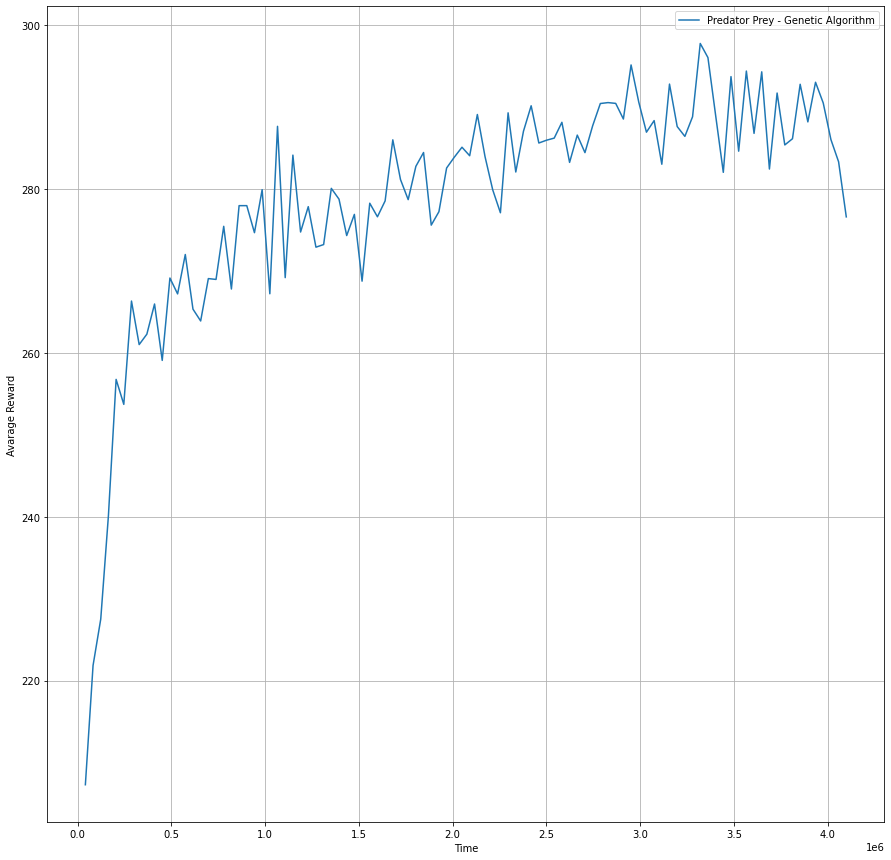

In [33]:
plt.figure(figsize=(15,15))
plt.plot(steps_x, fitness_y, label="Predator Prey - Genetic Algorithm")
plt.xlabel("Time")
plt.ylabel("Avarage Reward")
plt.grid(True)
plt.legend()
plt.show()

In [34]:
models[0]

In [35]:
model_trained = models[0]

## Save model

In [36]:
path_best_model = 'Training/my_model_PP_3_4M_GA'
model_trained.model.save(path_best_model)

INFO:tensorflow:Assets written to: Training/my_model_PP_3_4M_GA\assets


## Load model

In [37]:
path_best_model = 'Training/my_model_PP_3_4M_GA'
model = keras.models.load_model(path_best_model)

In [38]:
obs = env.reset()

In [39]:
'''
0 - direita
1 - esquerda
2 - cima
3 - baixo
'''

obs

array([[2, 2, 2, 2, 2],
       [0, 2, 2, 0, 2],
       [2, 0, 1, 0, 2],
       [2, 0, 0, 2, 0],
       [0, 0, 2, 2, 0]])

In [40]:
print(model_trained(obs.reshape(1, -1)).numpy(), model_trained(obs.reshape(1, -1)).numpy().argmax())

[[0. 0. 0. 1.]] 3


In [44]:
env.reset()

array([[0, 0, 2, 0, 2],
       [0, 0, 0, 2, 0],
       [2, 0, 1, 0, 0],
       [0, 0, 0, 0, 2],
       [2, 0, 2, 0, 0]])

In [45]:
[env.action_space.sample() for i in range(10)]

[3, 2, 2, 3, 0, 0, 3, 1, 3, 2]

In [46]:
for i in range(20):
    action = model_trained(obs.reshape(1, -1)).numpy().argmax()
    print(action)
    obs, _, _, _ = env.step(action)
    print(env.array, '\n')
    print(env.get_obs(), '\n')
    print(env.get_neighboors())
    print("-" * 30)

3
[[0 0 2 0 2]
 [0 0 0 2 0]
 [2 0 0 0 0]
 [0 0 1 0 2]
 [2 0 2 0 0]] 

[[0 0 0 2 0]
 [2 0 0 0 0]
 [0 0 1 0 2]
 [2 0 2 0 0]
 [0 0 2 0 2]] 

[0, 0, 0, 2]
------------------------------
3
[[0 0 2 0 2]
 [0 0 0 2 0]
 [2 0 0 0 0]
 [0 0 2 0 2]
 [2 0 1 0 0]] 

[[2 0 0 0 0]
 [0 0 2 0 2]
 [2 0 1 0 0]
 [0 0 2 0 2]
 [0 0 0 2 0]] 

[0, 0, 2, 2]
------------------------------
3
[[0 0 1 0 2]
 [0 0 0 2 0]
 [2 0 0 0 0]
 [0 0 2 0 2]
 [2 0 2 0 0]] 

[[0 0 2 0 2]
 [2 0 2 0 0]
 [0 0 1 0 2]
 [0 0 0 2 0]
 [2 0 0 0 0]] 

[0, 0, 2, 0]
------------------------------
2
[[0 0 2 0 2]
 [0 0 0 2 0]
 [2 0 0 0 0]
 [0 0 2 0 2]
 [2 0 1 0 0]] 

[[2 0 0 0 0]
 [0 0 2 0 2]
 [2 0 1 0 0]
 [0 0 2 0 2]
 [0 0 0 2 0]] 

[0, 0, 2, 2]
------------------------------
3
[[0 0 1 0 2]
 [0 0 0 2 0]
 [2 0 0 0 0]
 [0 0 2 0 2]
 [2 0 2 0 0]] 

[[0 0 2 0 2]
 [2 0 2 0 0]
 [0 0 1 0 2]
 [0 0 0 2 0]
 [2 0 0 0 0]] 

[0, 0, 2, 0]
------------------------------
2
[[0 0 2 0 2]
 [0 0 0 2 0]
 [2 0 0 0 0]
 [0 0 2 0 2]
 [2 0 1 0 0]] 

[[2 0 0 0 0]
 [0 0 2

In [575]:
episodes = 100
avg_total = 0
for ep in range(episodes):
    obs = env.reset().reshape(1, -1)
    done = False
    score = 0
    while not done:
        action = model(obs.reshape(1, -1)).numpy().argmax()
        obs, rew, done, info = env.step(action)
        if render:
            env.render()
        score += rew
    avg_total += score
    print(f"Ep: {ep} || Score: {score}")
print(f"Avg score: {avg_total / episodes}")

Ep: 0 || Score: 766
Ep: 1 || Score: 608
Ep: 2 || Score: 400
Ep: 3 || Score: 296
Ep: 4 || Score: 1181
Ep: 5 || Score: 369
Ep: 6 || Score: 1186
Ep: 7 || Score: 600
Ep: 8 || Score: 540
Ep: 9 || Score: 602
Ep: 10 || Score: 804
Ep: 11 || Score: 1208
Ep: 12 || Score: 804
Ep: 13 || Score: 1072
Ep: 14 || Score: 598
Ep: 15 || Score: 379
Ep: 16 || Score: 607
Ep: 17 || Score: 452
Ep: 18 || Score: 906
Ep: 19 || Score: 1130
Ep: 20 || Score: 296
Ep: 21 || Score: 777
Ep: 22 || Score: 796
Ep: 23 || Score: 785
Ep: 24 || Score: 668
Ep: 25 || Score: 988
Ep: 26 || Score: 864
Ep: 27 || Score: 611
Ep: 28 || Score: 600
Ep: 29 || Score: 489
Ep: 30 || Score: 586
Ep: 31 || Score: 848
Ep: 32 || Score: 982
Ep: 33 || Score: 404
Ep: 34 || Score: 634
Ep: 35 || Score: 596
Ep: 36 || Score: 920
Ep: 37 || Score: 484
Ep: 38 || Score: 1128
Ep: 39 || Score: 961
Ep: 40 || Score: 512
Ep: 41 || Score: 528
Ep: 42 || Score: 770
Ep: 43 || Score: 976
Ep: 44 || Score: 800
Ep: 45 || Score: 591
Ep: 46 || Score: 988
Ep: 47 || Score: 

In [576]:
episodes = 100
avg_total = 0
for ep in range(episodes):
    obs = env.reset().reshape(1, -1)
    done = False
    score = 0
    while not done:
        action = model(obs.reshape(1, -1)).numpy().argmax()
        obs, rew, done, info = env.step(env.action_space.sample())
        if render:
            env.render()
        score += rew
    avg_total += score
    print(f"Ep: {ep} || Score: {score}")
print(f"Avg score: {avg_total / episodes}")

Ep: 0 || Score: 537
Ep: 1 || Score: 469
Ep: 2 || Score: 523
Ep: 3 || Score: 561
Ep: 4 || Score: 660
Ep: 5 || Score: 504
Ep: 6 || Score: 572
Ep: 7 || Score: 513
Ep: 8 || Score: 446
Ep: 9 || Score: 438
Ep: 10 || Score: 688
Ep: 11 || Score: 558
Ep: 12 || Score: 543
Ep: 13 || Score: 561
Ep: 14 || Score: 454
Ep: 15 || Score: 505
Ep: 16 || Score: 496
Ep: 17 || Score: 529
Ep: 18 || Score: 471
Ep: 19 || Score: 417
Ep: 20 || Score: 897
Ep: 21 || Score: 456
Ep: 22 || Score: 451
Ep: 23 || Score: 624
Ep: 24 || Score: 645
Ep: 25 || Score: 601
Ep: 26 || Score: 505
Ep: 27 || Score: 490
Ep: 28 || Score: 530
Ep: 29 || Score: 644
Ep: 30 || Score: 496
Ep: 31 || Score: 521
Ep: 32 || Score: 565
Ep: 33 || Score: 410
Ep: 34 || Score: 388
Ep: 35 || Score: 588
Ep: 36 || Score: 407
Ep: 37 || Score: 653
Ep: 38 || Score: 477
Ep: 39 || Score: 353
Ep: 40 || Score: 613
Ep: 41 || Score: 476
Ep: 42 || Score: 525
Ep: 43 || Score: 464
Ep: 44 || Score: 384
Ep: 45 || Score: 572
Ep: 46 || Score: 497
Ep: 47 || Score: 499
Ep

In [49]:
### Carregando modelo
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

C:\Users\gabri\anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [50]:
PPO_path = os.path.join('Training', 'Saved Models', 'PP_PPO_1_2M')

In [51]:
model = PPO.load(PPO_path)

In [52]:
model

In [58]:
episodes = 100
avg_total = 0
for ep in range(episodes):
    obs = env.reset().reshape(1, -1)
    done = False
    score = 0
    while not done:
        action = model.predict(obs.reshape(1, -1))[0]
        obs, rew, done, info = env.step(env.action_space.sample())
        if render:
            env.render()
        score += rew
    avg_total += score
    print(f"Ep: {ep} || Score: {score}")
print(f"Avg score: {avg_total / episodes}")

Ep: 0 || Score: 192
Ep: 1 || Score: 186
Ep: 2 || Score: 137
Ep: 3 || Score: 266
Ep: 4 || Score: 129
Ep: 5 || Score: 255
Ep: 6 || Score: 141
Ep: 7 || Score: 211
Ep: 8 || Score: 231
Ep: 9 || Score: 286
Ep: 10 || Score: 153
Ep: 11 || Score: 131
Ep: 12 || Score: 190
Ep: 13 || Score: 268
Ep: 14 || Score: 191
Ep: 15 || Score: 420
Ep: 16 || Score: 236
Ep: 17 || Score: 117
Ep: 18 || Score: 290
Ep: 19 || Score: 129
Ep: 20 || Score: 175
Ep: 21 || Score: 274
Ep: 22 || Score: 152
Ep: 23 || Score: 146
Ep: 24 || Score: 161
Ep: 25 || Score: 169
Ep: 26 || Score: 169
Ep: 27 || Score: 223
Ep: 28 || Score: 256
Ep: 29 || Score: 201
Ep: 30 || Score: 246
Ep: 31 || Score: 202
Ep: 32 || Score: 158
Ep: 33 || Score: 155
Ep: 34 || Score: 255
Ep: 35 || Score: 120
Ep: 36 || Score: 254
Ep: 37 || Score: 237
Ep: 38 || Score: 307
Ep: 39 || Score: 229
Ep: 40 || Score: 246
Ep: 41 || Score: 187
Ep: 42 || Score: 224
Ep: 43 || Score: 312
Ep: 44 || Score: 220
Ep: 45 || Score: 183
Ep: 46 || Score: 126
Ep: 47 || Score: 277
Ep